### Crack Segmentation on deep crack dataset.


### Dataset = DEEP CRACK
### Optimiser=adam_and_beyond



### Importing the neccessary libraries and mounting the google drive

In [ ]:
! nvidia-smi

Wed Jun 26 14:26:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
import os
import cv2
import shutil
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Add, concatenate, average, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from albumentations import Compose, OneOf, Flip, Rotate, RandomContrast, RandomGamma, RandomBrightness, ElasticTransform, GridDistortion, OpticalDistortion, RGBShift, CLAHE

In [ ]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from skimage.transform import resize
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the dataset

### Input Pipeline
* The data is loaded with its respective masks
* The data is then shuffled
* Splited & Divided into train,test and validation sets








In [ ]:
# Directorios de datos
train_image_dir = r'/content/drive/MyDrive/DeepCrack/train_img'
train_mask_dir = r'/content/drive/MyDrive/DeepCrack/train_lab'

test_image_dir = r'/content/drive/MyDrive/DeepCrack/test_img'
test_mask_dir = r'/content/drive/MyDrive/DeepCrack/test_lab'

In [ ]:
# Cargar rutas de archivos de imágenes y máscaras
train_image_paths = sorted([os.path.join(train_image_dir, fname) for fname in os.listdir(train_image_dir) if fname.endswith(".jpg") and not fname.startswith(".")])
train_mask_paths = sorted([os.path.join(train_mask_dir, fname) for fname in os.listdir(train_mask_dir) if fname.endswith(".png") and not fname.startswith(".")])

test_image_paths = sorted([os.path.join(test_image_dir, fname) for fname in os.listdir(test_image_dir) if fname.endswith(".jpg") and not fname.startswith(".")])
test_mask_paths = sorted([os.path.join(test_mask_dir, fname) for fname in os.listdir(test_mask_dir) if fname.endswith(".png") and not fname.startswith(".")])

# Verificar número de imágenes y máscaras
print("Number of training images : ", len(train_image_paths))
print("Number of training masks : ", len(train_mask_paths))
print('\n')
print("Number of testing images : ", len(test_image_paths))
print("Number of testing masks : ", len(test_mask_paths))



Number of training images :  300
Number of training masks :  300


Number of testing images :  237
Number of testing masks :  237


In [ ]:
# Shuffle
import random
combined = list(zip(train_image_paths, train_mask_paths))
random.shuffle(combined)

train_image_paths[:], train_mask_paths[:] = zip(*combined)

In [ ]:
# Opción 2: Splitting manual
train_image_files = train_image_paths[:270]
train_mask_files = train_mask_paths[:270]

valid_image_files = train_image_paths[270:]
valid_mask_files = train_mask_paths[270:]

print(len(train_image_files), len(train_mask_files))
print(len(valid_image_files), len(valid_mask_files))

270 270
30 30


## Generator creation
* A custom generator is created which combines the  image with its repective masks.
* All data is augmented using albumentation library.
* Random flips and rotations along with more attributes of the albumentation library are used to augment the images present in the training data

In [ ]:
batch_size = 10
img_dim = (256, 256)

In [ ]:

class Generator(Sequence):

  def __init__(self, x_set, y_set, batch_size=5, img_dim=(128, 128), augment=False):
      self.x = x_set
      self.y = y_set
      self.batch_size = batch_size
      self.img_dim = img_dim
      self.augment = augment

  def __len__(self):
      return math.ceil(len(self.x) / self.batch_size)

  augmentations = Compose(
    [
      Flip(p=0.7),
      Rotate(p=0.7),
      OneOf([
              RandomContrast(),
              RandomGamma(),
              RandomBrightness()
            ], p=0.3),
      OneOf([
              ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
              GridDistortion(),
              OpticalDistortion(distort_limit=2, shift_limit=0.5)
            ], p=0.3),
    ])

  def __getitem__(self, idx):
      batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

      batch_x = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (self.img_dim[1], self.img_dim[0])) for file_name in batch_x])
      batch_y = np.array([(cv2.resize(cv2.imread(file_name, -1), (self.img_dim[1], self.img_dim[0]))>0).astype(np.uint8) for file_name in batch_y])

      if self.augment is True:
        aug = [self.augmentations(image=i, mask=j) for i, j in zip(batch_x, batch_y)]
        batch_x = np.array([i['image'] for i in aug])
        batch_y = np.array([j['mask'] for j in aug])

      batch_y = np.expand_dims(batch_y, -1)

      return batch_x/255, batch_y/1

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [ ]:

train_generator = Generator(train_image_files, train_mask_files)
validation_generator = Generator(valid_image_files, valid_mask_files)
test_generator=Generator(test_image_paths,test_mask_paths)


In [ ]:
for i, j in train_generator:
  break

print(i.shape)
print(j.shape)

(5, 128, 128, 3)
(5, 128, 128, 1)


In [ ]:
for i, j in validation_generator:
  break

print(i.shape)
print(j.shape)

(5, 128, 128, 3)
(5, 128, 128, 1)


In [ ]:
for i,j in test_generator:
  break
print(i.shape)
print(j.shape)

(5, 128, 128, 3)
(5, 128, 128, 1)


### Plotting of the unaugmented images along with known images

> Añadir blockquote



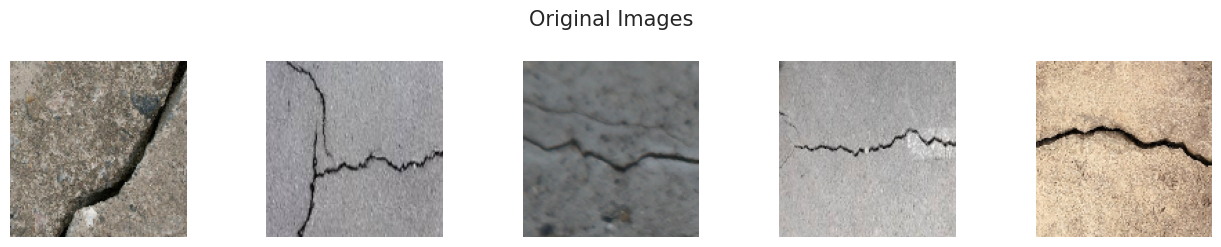

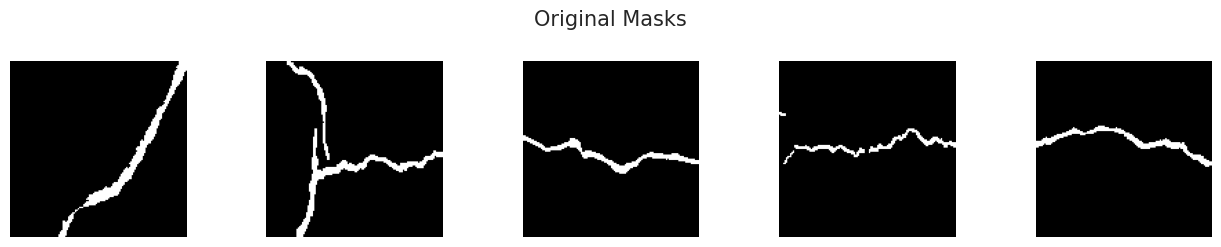

In [ ]:

# Train generator samples (Un-augmented)
for i, j in train_generator:
    break

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

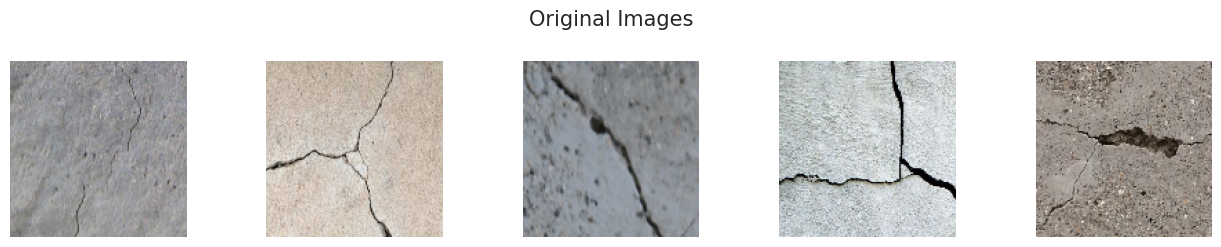

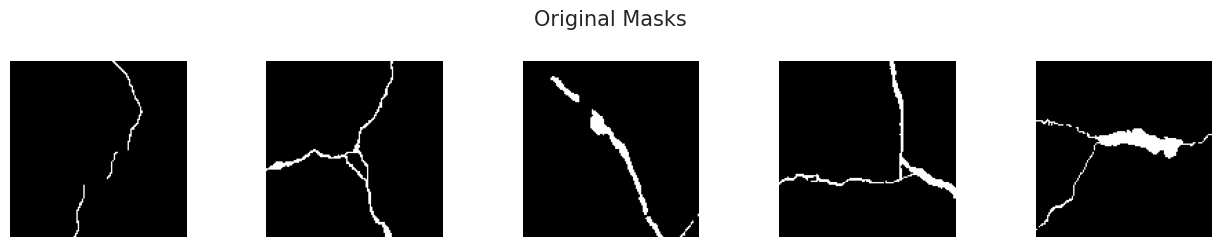

In [ ]:

# Validation generator samples (Un-augmented)
for i, j in validation_generator:
    break

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()


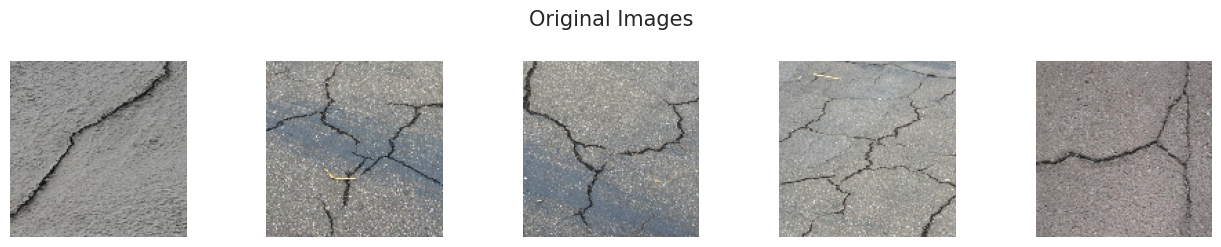

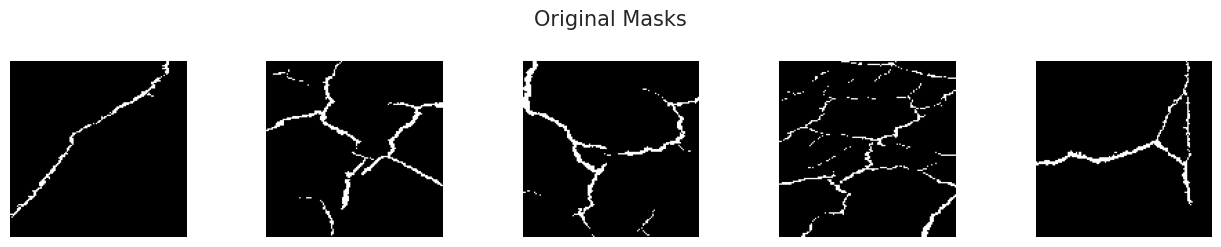

In [ ]:

# test generator samples (Un-augmented)
for i, j in test_generator:
    break

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:

tg = Generator(train_image_files, train_mask_files, batch_size, img_dim, augment = True)
vg = Generator(valid_image_files, valid_mask_files, batch_size, img_dim, augment = False)
testg=Generator(test_image_paths,test_mask_paths,batch_size,img_dim,augment=False)


In [ ]:
for i, j in tg:
  break

print(i.shape)
print(j.shape)

(10, 256, 256, 3)
(10, 256, 256, 1)


In [ ]:
for i, j in vg:
  break

print(i.shape)
print(j.shape)

(10, 256, 256, 3)
(10, 256, 256, 1)


In [ ]:
for i, j in tg:
  break

print(i.shape)
print(j.shape)

(10, 256, 256, 3)
(10, 256, 256, 1)


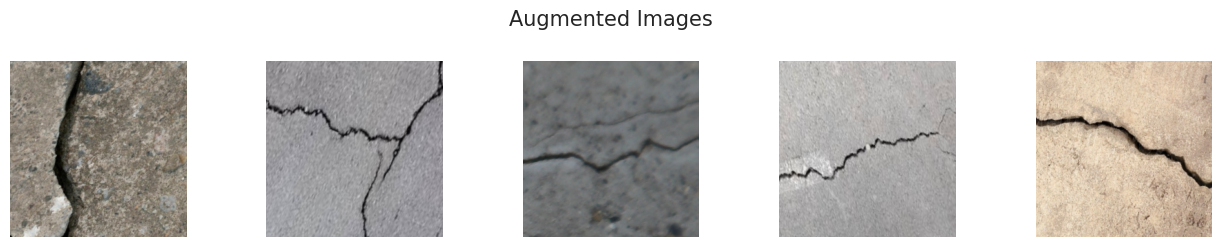

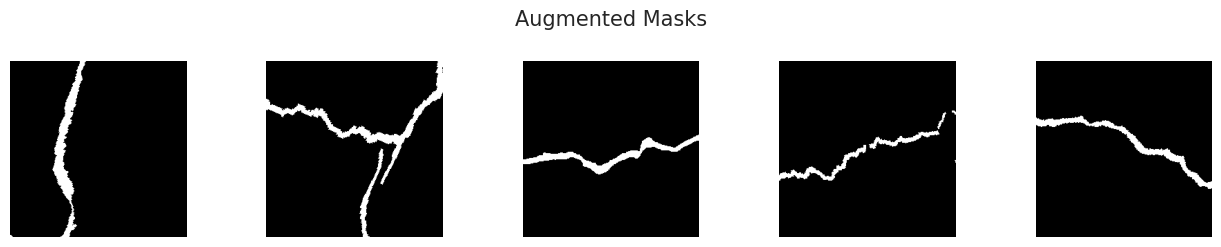

In [ ]:
# Augmented train
for i, j in tg:
    break

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Augmented Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Augmented Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

#Model

Importación de Librerías y Definición de Funciones Auxiliares

In [ ]:
import os
import numpy as np
import cv2
import math
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

In [ ]:
# Función para construir un bloque convolucional con batch normalization y activación ReLU
def conv_block(inputs, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(inputs)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    return conv

# Función para construir el bloque de down-sampling (encoder)
def down_block(inputs, filters, pool=True):
    conv = conv_block(inputs, filters)
    if pool:
        pool = MaxPooling2D(pool_size=(2, 2))(conv)
        return conv, pool
    else:
        return conv

# Función para construir el bloque de up-sampling (decoder)
def up_block(inputs, skip, filters, concat=True):
    up = UpSampling2D(size=(2, 2))(inputs)
    if concat:
        up = Concatenate()([up, skip])
    conv = conv_block(up, filters)
    return conv

# Función para construir el modelo UNet completo
def UNet(img_shape=(256, 256, 3), num_classes=1, filters=64):
    inputs = Input(img_shape)

    # Encoder
    d1, p1 = down_block(inputs, filters)
    d2, p2 = down_block(p1, filters*2)
    d3, p3 = down_block(p2, filters*4)
    d4, p4 = down_block(p3, filters*8)

    # Bottleneck
    bn = conv_block(p4, filters*16)

    # Decoder
    u1 = up_block(bn, d4, filters*8)
    u2 = up_block(u1, d3, filters*4)
    u3 = up_block(u2, d2, filters*2)
    u4 = up_block(u3, d1, filters)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(u4)

    model = Model(inputs, outputs)
    return model

In [ ]:
K.clear_session()
model = UNet()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0][0

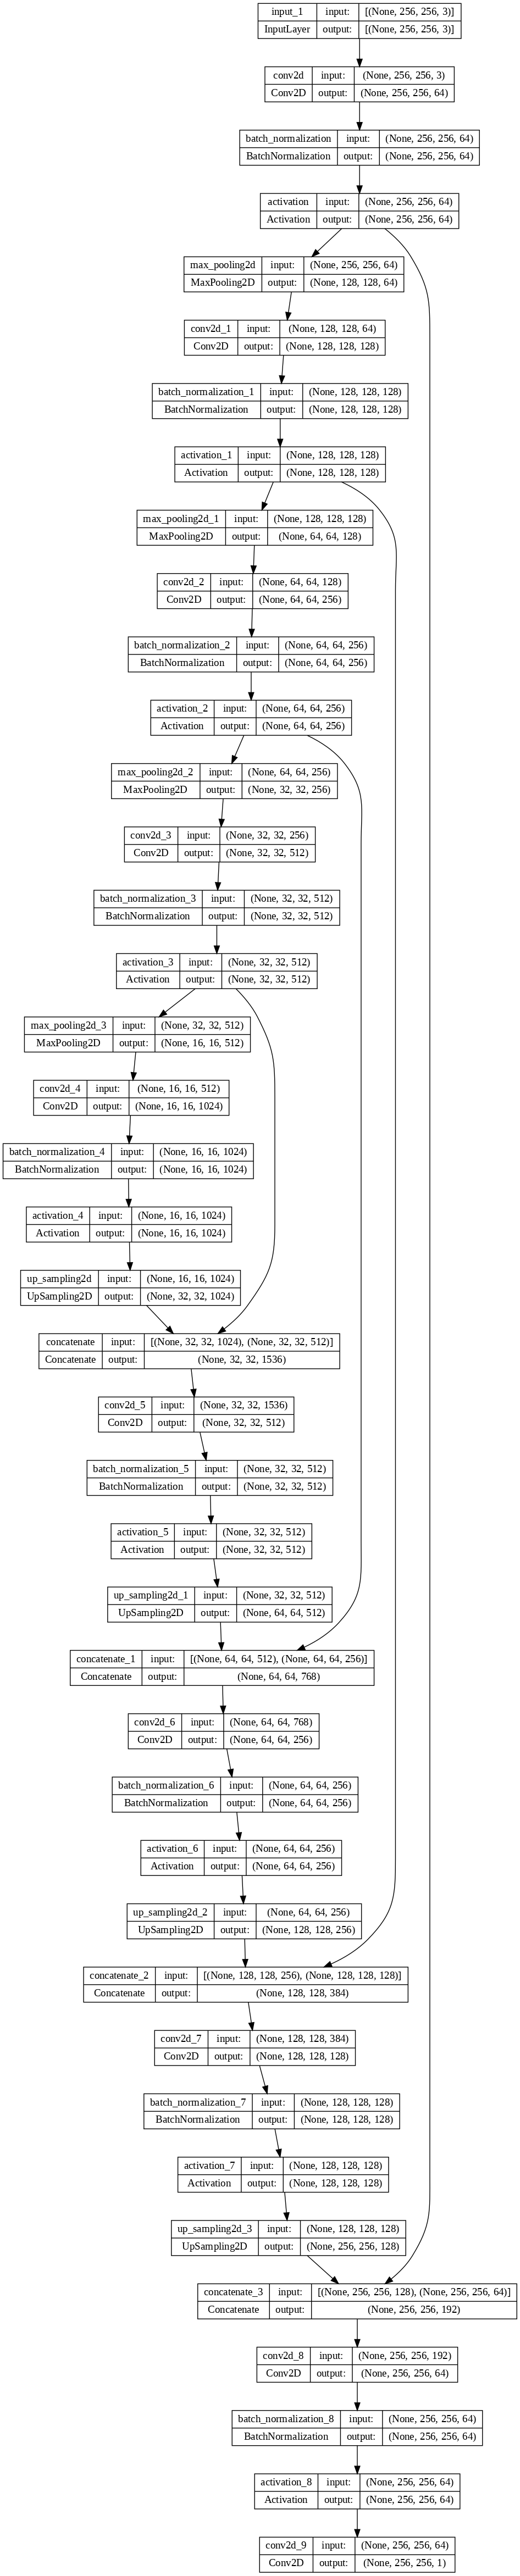

In [ ]:
from tensorflow.keras.utils import  plot_model

plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=100,
)

# Loss Function


In [ ]:

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def IOU(y_true, y_pred):

    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    thresh = 0.5

    y_true = K.cast(K.greater_equal(y_true, thresh), 'float32')
    y_pred = K.cast(K.greater_equal(y_pred, thresh), 'float32')

    union = K.sum(K.maximum(y_true, y_pred)) + K.epsilon()
    intersection = K.sum(K.minimum(y_true, y_pred)) + K.epsilon()

    iou = intersection/union

    return iou

# def bce_dice_loss(y_true, y_pred):

#     return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

### Learning Rate Schedular And other callbacks

In [ ]:
def lr_schedule(epoch):
    lr =0.001
    if epoch >150:
        lr *=2**-1
    elif epoch >80:
        lr *=2**(-1)
    elif epoch >50:
        lr *=2**(-1)
    elif epoch >30:
        lr *=2**(-1)

    print('Learning rate: ', lr)
    return lr

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD

In [ ]:
import time

start_time = time.time()

# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-8)

callbacks = [lr_reducer, lr_scheduler]


In [ ]:
import tensorflow as tf
optimiser=tf.keras.optimizers.Adam(
    learning_rate=lr_schedule(0),
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,
    name="Adam"
)
model.compile(optimizer =optimiser , loss = dice_coef_loss, metrics = ['accuracy', IOU, dice_coef])

Learning rate:  0.001


In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/Adam_and_beyond.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training

## Training

In [ ]:
train_steps = len(train_image_files)//batch_size
valid_steps = len(valid_image_files)//batch_size

history = model.fit(
    tg,
    steps_per_epoch=train_steps,
    initial_epoch = 0,
    epochs=5, #inicialmente era 100
    validation_data = vg,
    validation_steps = valid_steps,callbacks=callbacks)

Learning rate:  0.001
Epoch 1/5
27/27 [==============================] - 12s 435ms/step - loss: 0.2317 - accuracy: 0.9844 - IOU: 0.6428 - dice_coef: 0.7683 - val_loss: 0.9002 - val_accuracy: 0.9704 - val_IOU: 0.0515 - val_dice_coef: 0.0998 - lr: 0.0010
Learning rate:  0.001
Epoch 2/5
27/27 [==============================] - 12s 429ms/step - loss: 0.2183 - accuracy: 0.9854 - IOU: 0.6595 - dice_coef: 0.7817 - val_loss: 0.8617 - val_accuracy: 0.9712 - val_IOU: 0.0747 - val_dice_coef: 0.1383 - lr: 0.0010
Learning rate:  0.001
Epoch 3/5
27/27 [==============================] - 12s 420ms/step - loss: 0.2242 - accuracy: 0.9850 - IOU: 0.6519 - dice_coef: 0.7758 - val_loss: 0.5496 - val_accuracy: 0.9776 - val_IOU: 0.2955 - val_dice_coef: 0.4504 - lr: 0.0010
Learning rate:  0.001
Epoch 4/5
27/27 [==============================] - 12s 444ms/step - loss: 0.2132 - accuracy: 0.9856 - IOU: 0.6641 - dice_coef: 0.7868 - val_loss: 0.5989 - val_accuracy: 0.9763 - val_IOU: 0.2547 - val_dice_coef: 0.4011 -

In [ ]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

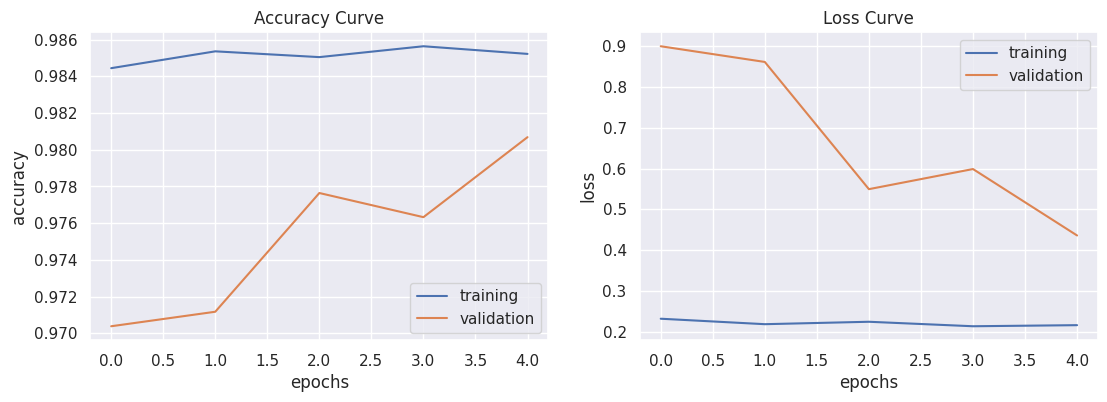

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(13,4))
axes = axes.flatten()

axes[0].plot(train_acc, label='training')
axes[0].plot(valid_acc, label='validation')
axes[0].set_title('Accuracy Curve')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].legend()


axes[1].plot(train_loss, label='training')
axes[1].plot(valid_loss, label='validation')
axes[1].set_title('Loss Curve')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].legend()

plt.show()

In [ ]:
train_dice = history.history['dice_coef']
valid_dice = history.history['val_dice_coef']


train_IOU = history.history['IOU']
valid_IOU = history.history['val_IOU']

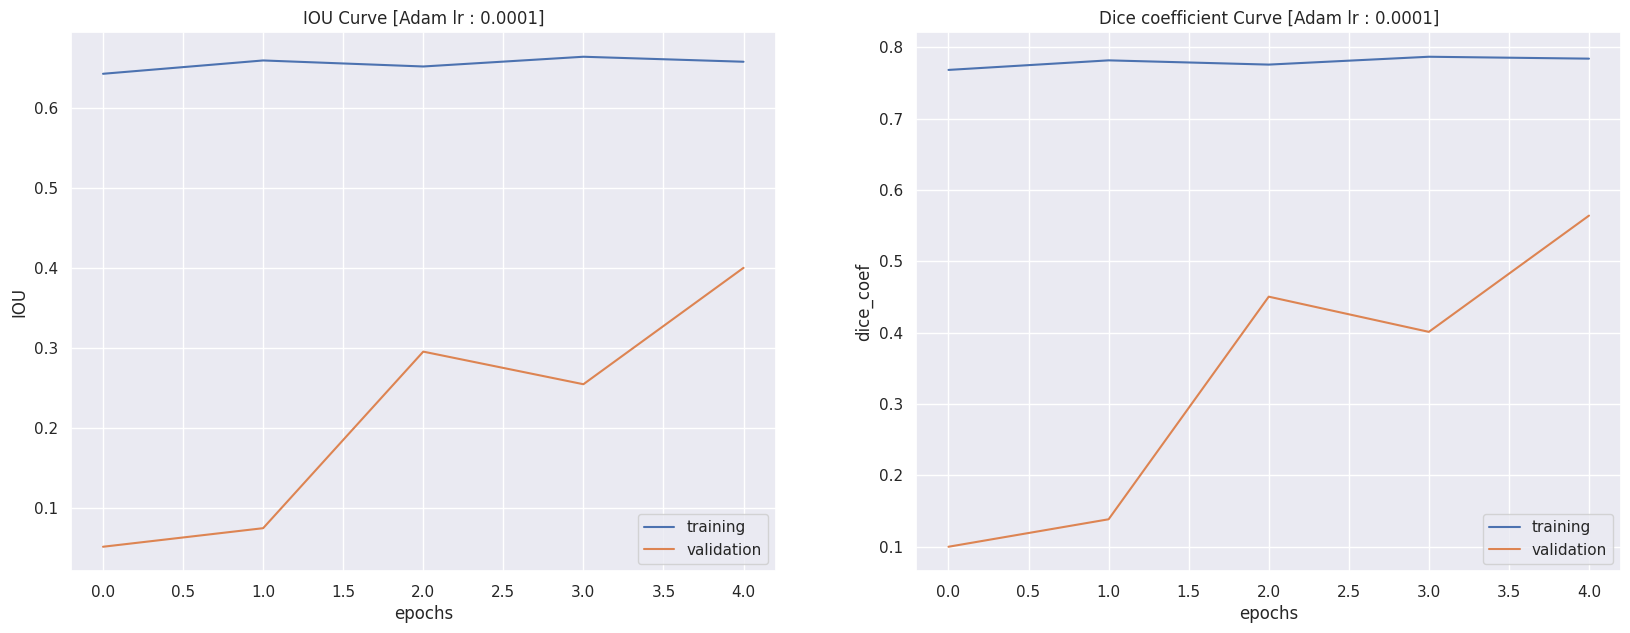

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))
axes = axes.flatten()

axes[0].plot(train_IOU, label='training')
axes[0].plot(valid_IOU, label='validation')
axes[0].set_title('IOU Curve [Adam lr : 0.0001]')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('IOU')
axes[0].legend()


axes[1].plot(train_dice, label='training')
axes[1].plot(valid_dice, label='validation')
axes[1].set_title('Dice coefficient Curve [Adam lr : 0.0001]')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('dice_coef')
axes[1].legend()

plt.show()

## Testing

In [ ]:
test_generator = Generator(valid_image_files, valid_mask_files,30 , img_dim)

for x_test, y_test in test_generator:
  break

y_pred = model.predict(x_test)

yy_true = (y_test>0.5).flatten()
yy_pred = (y_pred>0.5).flatten()

1/1 [==============================] - 0s 30ms/step


In [ ]:
report = classification_report(yy_true, yy_pred, output_dict=True)

Accuracy = accuracy_score(yy_true, yy_pred)

Precision = report['True']['precision']
Recall = report['True']['recall']
F1_score = report['True']['f1-score']

Sensitivity = Recall
Specificity = report['False']['recall']

AUC = roc_auc_score(y_test.flatten(), y_pred.flatten())

IOU = (Precision*Recall)/(Precision+Recall-Precision*Recall)

print("Accuracy: {0:.4f}\n".format(Accuracy))
print("Precision: {0:.4f}\n".format(Precision))
print("Recall: {0:.4f}\n".format(Recall))
print("F1-Score: {0:.4f}\n".format(F1_score))
print("Sensitivity: {0:.4f}\n".format(Sensitivity))
print("Specificity: {0:.4f}\n".format(Specificity))
print("AUC: {0:.4f}\n".format(AUC))
print("IOU: {0:.4f}\n".format(IOU))
print('-'*50,'\n')
print(classification_report(yy_true, yy_pred))

Accuracy: 0.9807

Precision: 0.9583

Recall: 0.3996

F1-Score: 0.5640

Sensitivity: 0.3996

Specificity: 0.9994

AUC: 0.8166

IOU: 0.3927

-------------------------------------------------- 

              precision    recall  f1-score   support

       False       0.98      1.00      0.99   1904616
        True       0.96      0.40      0.56     61464

    accuracy                           0.98   1966080
   macro avg       0.97      0.70      0.78   1966080
weighted avg       0.98      0.98      0.98   1966080



In [ ]:
test_generator = Generator(test_image_paths, test_mask_paths,237, img_dim)

for x_test, y_test in test_generator:
  break

y_pred = model.predict(x_test)

yy_true = (y_test>0.5).flatten()
yy_pred = (y_pred>0.5).flatten()

8/8 [==============================] - 31s 2s/step


In [ ]:
report = classification_report(yy_true, yy_pred, output_dict=True)

Accuracy = accuracy_score(yy_true, yy_pred)

Precision = report['True']['precision']
Recall = report['True']['recall']
F1_score = report['True']['f1-score']

Sensitivity = Recall
Specificity = report['False']['recall']

AUC = roc_auc_score(y_test.flatten(), y_pred.flatten())

IOU = (Precision*Recall)/(Precision+Recall-Precision*Recall)

print("Accuracy: {0:.4f}\n".format(Accuracy))
print("Precision: {0:.4f}\n".format(Precision))
print("Recall: {0:.4f}\n".format(Recall))
print("F1-Score: {0:.4f}\n".format(F1_score))
print("Sensitivity: {0:.4f}\n".format(Sensitivity))
print("Specificity: {0:.4f}\n".format(Specificity))
print("AUC: {0:.4f}\n".format(AUC))
print("IOU: {0:.4f}\n".format(IOU))
print('-'*50,'\n')
print(classification_report(yy_true, yy_pred))

Accuracy: 0.9703

Precision: 0.9804

Recall: 0.3948

F1-Score: 0.5629

Sensitivity: 0.3948

Specificity: 0.9996

AUC: 0.8352

IOU: 0.3917

-------------------------------------------------- 

              precision    recall  f1-score   support

       False       0.97      1.00      0.98  14780073
        True       0.98      0.39      0.56    751959

    accuracy                           0.97  15532032
   macro avg       0.98      0.70      0.77  15532032
weighted avg       0.97      0.97      0.96  15532032



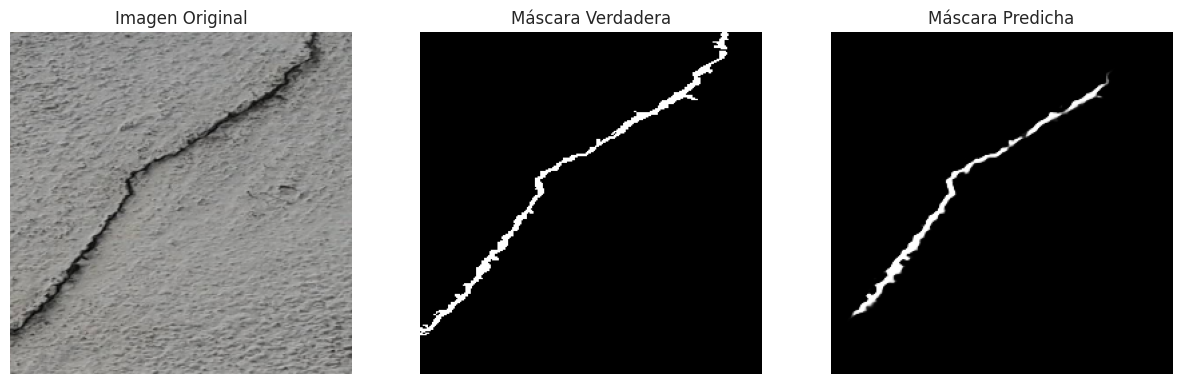

In [ ]:

# Mostrar la imagen original, la máscara verdadera y la máscara predicha
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(x_test[0], cmap='gray')
ax[0].set_title('Imagen Original')
ax[0].axis('off')

ax[1].imshow(y_test[0].squeeze(), cmap='gray')
ax[1].set_title('Máscara Verdadera')
ax[1].axis('off')

ax[2].imshow(y_pred[0].squeeze(), cmap='gray')
ax[2].set_title('Máscara Predicha')
ax[2].axis('off')

plt.show()